In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, activations

In [13]:
latent_dim = 2

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation=activations.relu, strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation=activations.relu)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 32)           320       ['input_5[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_6[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 3136)                 0         ['conv2d_7[0][0]']            
                                                                                            

In [14]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation=activations.relu)(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation=activations.relu, strides=2, padding='same')(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=3, activation=activations.relu, strides=2, padding='same')(x)
decoder_outputs = layers.Conv2D(filters=1, kernel_size=3, activation=activations.sigmoid, padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      


                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 65089 (254.25 KB)
Trainable params: 65089 (254.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.regularization_loss_tracker = keras.metrics.Mean(name='regularization_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.regularization_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            regularization_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + regularization_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.regularization_loss_tracker.update_state(regularization_loss)
        
        return {'total_loss': self.total_loss_tracker.result(),
                'reconstruction_loss': self.reconstruction_loss_tracker.result(),
                'regularization_loss': self.regularization_loss_tracker.result()}

In [26]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
print(mnist_digits.shape)
mnist_digits = np.expand_dims(mnist_digits, -1).astype(np.float32) / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

(70000, 28, 28)
Epoch 1/30
547/547 [==============================] - 34s 63ms/step - total_loss: 208.2444 - reconstruction_loss: 207.0416 - regularization_loss: 1.1982
Epoch 2/30
547/547 [==============================] - 34s 62ms/step - total_loss: 169.7550 - reconstruction_loss: 166.4385 - regularization_loss: 3.3171
Epoch 3/30
547/547 [==============================] - 33s 61ms/step - total_loss: 162.3271 - reconstruction_loss: 158.9520 - regularization_loss: 3.3742
Epoch 4/30
547/547 [==============================] - 33s 61ms/step - total_loss: 158.6678 - reconstruction_loss: 155.1947 - regularization_loss: 3.4735
Epoch 5/30
547/547 [==============================] - 33s 60ms/step - total_loss: 156.2844 - reconstruction_loss: 152.7581 - regularization_loss: 3.5268
Epoch 6/30
547/547 [==============================] - 33s 60ms/step - total_loss: 154.6737 - reconstruction_loss: 151.1051 - regularization_loss: 3.5702
Epoch 7/30
547/547 [==============================] - 33s 60ms/ste

1/1 [==============================] - 0s 10ms/step


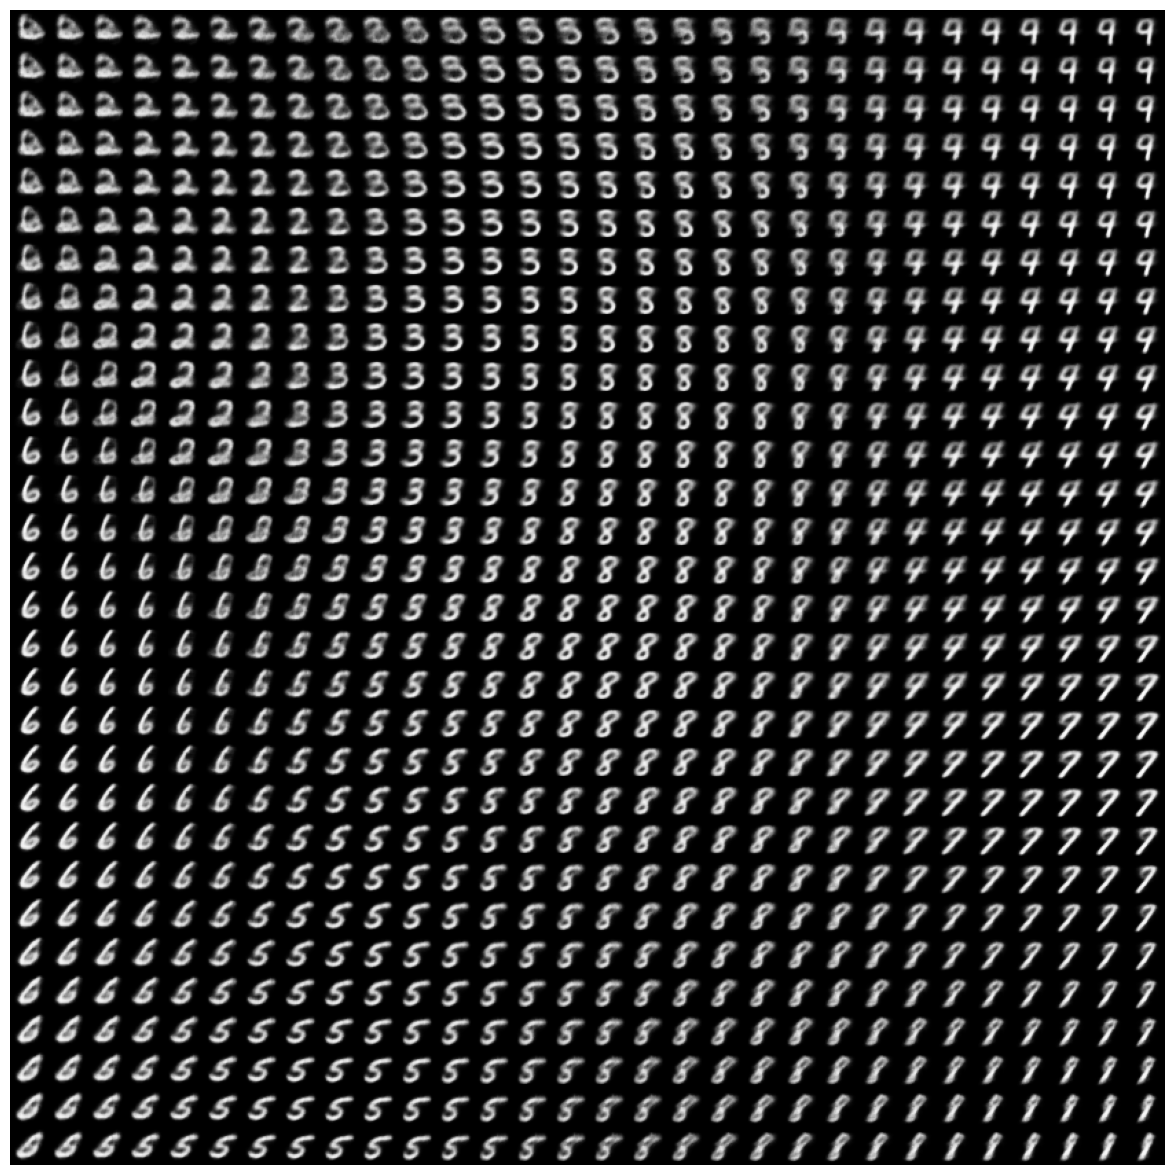

In [30]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xj in enumerate(grid_x):
        z_sample = np.array([[xj, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.axis('off')
plt.imshow(figure, cmap='Greys_r')
